# GGD27 / HH80/81 / IRAS18162

# Conclusion:
There are no lines coincident with NaCl.  This is a line-poor source with nothing to stack up on.  CH3CN and other common species are prominently detected.  There's something fairly unique and interesting going on here, but not salt.

References:
 * https://ui.adsabs.harvard.edu/abs/2020ApJ...888...41A/abstract - modeling accretion disk

In [1]:
from astropy import units as u
distance = 1.3*u.kpc

In [2]:
cd /orange/adamginsburg/salt/sanhueza/IRAS18162

/orange/adamginsburg/salt/sanhueza/IRAS18162


In [3]:
ls

cutout2.reg
cutout.reg
GGD27_cutout.reg
GGD27.reg
I18192_Sanhueza_NaCl_PV_withcolorcurves.png
I18192_Sanhueza_SO_PV_withcolorcurves.png
I18192_Sanhueza_Water_PV_withcolorcurves.png
IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw0.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw0.robust0.5.image_small.fits
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw1.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw1.robust0.5.image_small.fits
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw2.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw2.robust0.5.image_small.fits
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw3.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw3.robust0.5.image_small.fits
NaCl_v_le_3_stackcube.fits
spectra/
vmap_GGD27.fi

In [4]:
targetname = 'IRAS_181622048'

for fn in glob.glob("*.fits"):
    print('app

In [5]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['font.size'] = 16
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2ad09a997730>

In [6]:
from astropy.table import Table
from astropy import table

In [7]:
import pprint

In [8]:
import scipy, scipy.ndimage

In [9]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.7) doesn't match a supported version!


In [10]:
import sys
import imp

sys.path.insert(0,'/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import paths
imp.reload(paths) # we need orion's paths loaded

from show_pv import show_pv
import show_pv
imp.reload(show_pv)

from show_pv import show_keplercurves, show_pv

In [11]:
!ln cutout.reg GGD27_cutout.reg

ln: failed to create hard link ‘GGD27_cutout.reg’: File exists


In [12]:
!ln cutout.reg GGD27.reg

ln: failed to create hard link ‘GGD27.reg’: File exists


In [13]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('GGD27_cutout.reg')
#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [14]:
reg[0].center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (10.8413657, -2.59164061)>

(2603.0, 2818.0, 2269.0, 2469.0)

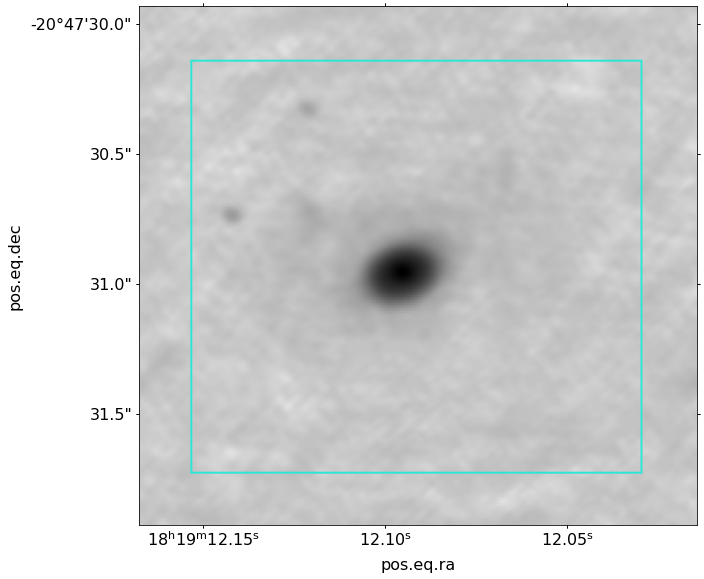

In [15]:
cont = SpectralCube.read('IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
#reg2[0].to_pixel(cont[0].wcs).plot(ax=ax)
#reg3[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [16]:
from spectral_cube.analysis_utilities import stack_cube

In [17]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [18]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [19]:
flist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_small.fits'))

In [20]:
flist

['IRAS_181622048.config8.spw3.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw1.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw2.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw0.robust0.5.image_small.fits']

In [21]:
#from dask.diagnostics import ProgressBar
#pbar = ProgressBar()
#pbar.register()

import dask
dask.config.set(scheduler='threads', num_workers=8)

In [22]:
for fn in flist:
    for rr,regn in ( (reg, 'co1'), ):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
            cube = SpectralCube.read(fn, use_dask=False).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            #with cube.use_dask_scheduler('threads', num_workers=8):
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb).to(u.K)
            scube.write(outfile, overwrite=True)

In [23]:
regn = "co1"
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862707361.400 Hz:218747086033.577 Hz,
 DaskSpectralCube with shape=(1930, 159, 173) and unit=K and chunk size (386, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062952403.500 Hz:232946842768.170 Hz,
 DaskSpectralCube with shape=(1931, 159, 173) and unit=K and chunk size (609, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s: 

In [24]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()
jtok = cb.jtok(217*u.GHz)

In [25]:
cb

Beam: BMAJ=0.10128964265536967 arcsec BMIN=0.07010411928578207 arcsec BPA=94.61941528320312 deg

In [26]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 131.67653545 AU>

In [27]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 91.13535507 AU>

In [28]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [29]:
from astropy import log
log.setLevel('INFO')

In [30]:
vcen = 14.5 * u.km/u.s # from Patricio
vcen = 11.8*u.km/u.s # Manuel Fernandez+ : https://arxiv.org/pdf/1107.3176.pdf
vcen = 12.5*u.km/u.s # Anez-Lopez

In [31]:
#log.setLevel('DEBUG')
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-25*u.km/u.s,
                   vmax=vcen+25*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [32]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(75, 159, 173) and unit=K:
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -12.380 km / s:      37.317 km / s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


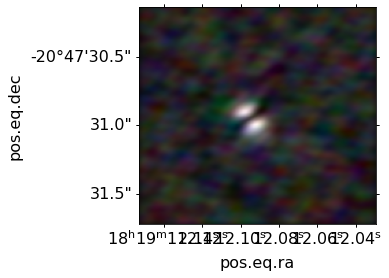

In [33]:
m0b = stackc.spectral_slab(vcen-15*u.km/u.s, vcen-5*u.km/u.s).moment0()
m0g = stackc.spectral_slab(vcen-5*u.km/u.s, vcen+5*u.km/u.s).moment0()
m0r = stackc.spectral_slab(vcen+5*u.km/u.s, vcen+15*u.km/u.s).moment0()
ax = pl.subplot(projection=m0b.wcs.celestial)
rgb = np.array([m0r.value, m0g.value, m0b.value]).swapaxes(0,2).swapaxes(0,1)
rgb /= rgb.max()
ax.imshow(rgb, origin='lower')

INFO: Auto-setting vmin to -2.411e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.803e+02 [aplpy.core]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

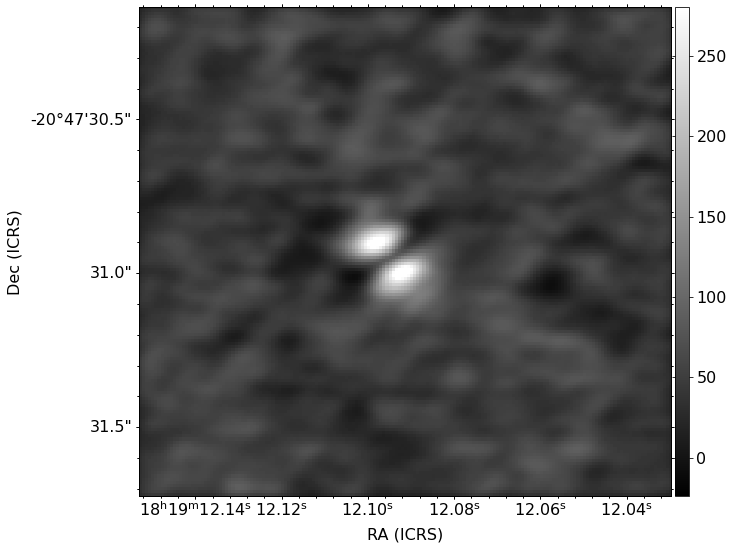

In [34]:
m0r.quicklook()
pl.colorbar()

In [ ]:
cont = SpectralCube.read('IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits').to(u.K)
cont

In [ ]:
yc,xc = np.unravel_index(np.nanargmax(cont[0]), cont[0].shape)

In [ ]:
fig = pl.figure()
fig.add_subplot(projection=cont.wcs.celestial)
ax = fig.gca()
ax.imshow(cont[0].value, cmap='gray_r')
#ax.axis((2460,2550,2530,2610))
ax.axis((xc-50,xc+50,yc-50,yc+50))
ax.contour(m0r, colors=['r']*5, levels=[100,200,300], linewidths=[0.75]*5, transform=ax.get_transform(m0r.wcs.celestial))
ax.contour(m0b, colors=['b']*5, levels=[100,200,300], linewidths=[0.75]*5, transform=ax.get_transform(m0b.wcs.celestial))

In [ ]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
watercube = scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                                                          velocity_convention='radio',
                                                          rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.04*jtok
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 20*u.K).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

In [ ]:
import pvextractor
center = coordinates.SkyCoord('18h19m12.0955s', '-20:47:30.948', unit=u.deg, frame='icrs')
PA = 113*u.deg
path = pvextractor.Path(coordinates.SkyCoord([center.directional_offset_by(PA, 1.5*u.arcsec), center.directional_offset_by(180*u.deg+PA, 1.5*u.arcsec)]))

In [ ]:
pvd_water = pvextractor.extract_pv_slice(watercube, path)

In [ ]:
fig,ax,cb,con = show_pv(pvd_water.data, wcs.WCS(pvd_water.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen,
                        imvmin=np.nanpercentile(pvd_water.data, 3), imvmax=np.nanmax(pvd_water.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_Water_PV_withcolorcurves.png")
#pl.legend(loc='best')

In [ ]:
# try creating a vmap based on another line (SO 65-54)
restval = 219.94944000*u.GHz # '': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
socube = scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 130*u.K
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1, projection=scube.wcs.celestial)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
ax2 = pl.subplot(1,2,2, projection=scube.wcs.celestial)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()
path.show_on_axis(ax1, spacing=1, color='w')
path.show_on_axis(ax2, spacing=1, color='w')


vmap = m1.hdu

In [ ]:
pvd_SO = pvextractor.extract_pv_slice(socube, path)

In [ ]:
fig,ax,cb,con = show_pv(pvd_SO.data, wcs.WCS(pvd_SO.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen, imvmin=np.nanpercentile(pvd_SO.data, 3), imvmax=np.nanmax(pvd_SO.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_SO_PV_withcolorcurves.png")
#pl.legend(loc='best')

In [ ]:
stackc = stackc.subcube_from_regions(reg)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 25*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=15)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu

In [ ]:
pvd_nacl = pvextractor.extract_pv_slice(stackc, path)

fig,ax,cb,con = show_pv(pvd_nacl.data, wcs.WCS(pvd_nacl.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen, imvmin=np.nanpercentile(pvd_nacl.data, 3), imvmax=np.nanmax(pvd_nacl.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_NaCl_PV_withcolorcurves.png")
#pl.legend(loc='best')

In [ ]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines, all_lines
'SO65-54' in all_lines

In [ ]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'GGD27 spw{ii} average'

In [ ]:
mkdir -p spectra/figures

In [ ]:
vcen

In [ ]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures', ymin=0, ymax=75, yfrac=0.55)

In [ ]:
ls -lhrt spectra/figures

In [ ]:
from IPython.display import Image,display

In [ ]:
for fn in glob.glob('spectra/figures/color*spw[01234].png'):
    display(Image(fn))

# Attempt to ID lines

In [ ]:
# verify velo w/SO
sp = spectra[3]
lx,ux = 219.93, 219.95
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=25, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit
((cen - 219.94944000*u.GHz) / (219.94944000*u.GHz) * constants.c).to(u.km/u.s)
#dx = (10*u.km/u.s / constants.c)*cen
#Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k')

In [ ]:
sp = spectra[0]
sp.plotter(xmax=216.95, xmin=216.92)
sp.baseline()
sp.plotter(xmax=216.95, xmin=216.92, ymin=-1, ymax=10)
sp.specfit(guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.specfit(guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
# CH3OHvt=0-2	Methanol	216.945521

In [ ]:
from astroquery.splatalogue import Splatalogue

In [ ]:
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k')

In [ ]:
sp = spectra[0]
lx,ux = 217.2, 217.25
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='DCN')
# DCN 217.238555

In [ ]:
sp = spectra[0]
lx,ux = 217.25, 217.4
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k',)


In [ ]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy import stats
from astropy.io import fits

cbflist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_co1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    print(basename)
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg)
    scube.allow_huge_operations=True
    # continuum subtract before stacking
    scube = scube - scube.percentile(25, axis=0)
    #mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    rms = stats.mad_std(sp)
    print(f"rms={rms}")
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap_GGD27.fits', overwrite=True)
    
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [ ]:
ls spectra

In [ ]:
from astropy.stats import mad_std

In [ ]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'GGD27 {spl[2]} stack'
    stackspectra.append(pysp)
    print(pysp.specname, mad_std(pysp.data))

In [ ]:
overplot_saltlines(stackspectra, vcen=vcen, savepath='spectra/figures', ymin=0, ymax=45, yfrac=0.55)

In [ ]:
pwd

In [ ]:
ls spectra/figures/

In [ ]:
for fn in glob.glob('spectra/figures/color*GGD*stack.png'):
    display(Image(fn))

In [ ]:
stackspectra

# Attempt to ID lines from stacked spectra

In [ ]:
# verify velo w/SO
sp = stackspectra[1]
lx,ux = 219.935, 219.96
sp.plotter()#xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.plotter(xmin=lx, xmax=ux)
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=75, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit
((cen - 219.94944000*u.GHz) / (219.94944000*u.GHz) * constants.c).to(u.km/u.s)
#dx = (10*u.km/u.s / constants.c)*cen
#Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k')

In [ ]:
sp = stackspectra[2]
sp.plotter(xmax=216.97, xmin=216.92)
sp.baseline()
sp.plotter(xmax=216.97, xmin=216.92, ymin=-1, ymax=15)
sp.specfit()#guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.plotter(xmax=216.97, xmin=216.92, ymin=-1, ymax=15)
sp.baseline(excludefit=True)
sp.plotter(xmax=216.97, xmin=216.92, ymin=-1, ymax=15)
sp.specfit()#guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
# CH3OHvt=0-2	Methanol	216.945521
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')


In [ ]:
sp = stackspectra[2]
lx,ux = 217.2, 217.27
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='DCN')
# DCN 217.238555

In [ ]:
sp = stackspectra[2]
lx,ux = 217.27, 217.32
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=2000, energy_type='eu_k')
# 13CN or CaCl?

In [ ]:
sp = stackspectra[2]
lx,ux = 217.8, 217.85
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Sulfur')
# 33SO 65-54

In [ ]:
sp = stackspectra[2]
lx,ux = 217.85, 217.92
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OHvt=0-2	Methanol	217.886504	2.2e-05	--	--	20(-1,19)-20(-0,20)E,vt=0 ?

In [ ]:
sp = stackspectra[2]
lx,ux = 218.2, 218.25
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=50)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Formaldehyde')
# H2CO

In [ ]:
sp = stackspectra[2]
lx,ux = 218.3, 218.35
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=10)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='HC3N')
# HC3Nv=0	Cyanoacetylene	--	--	218.324723	1e-05	J=24-23	

In [ ]:
sp = stackspectra[2]
lx,ux = 218.42, 218.46
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=50)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OHvt=0-2	Methanol	218.440063	1.3e-05	--	--	4(-2,3)-3(-1,2)E,vt=0	

In [ ]:
sp = stackspectra[2]
lx,ux = 218.46, 218.5
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=50)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Formaldehyde')
## H2CO

In [ ]:
sp = stackspectra[1]
lx,ux = 219.5, 219.6
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
### C18O

In [ ]:
sp = stackspectra[1]
lx,ux = 219.7, 219.75
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Isocyanic')
### HNCOv=0	Isocyanic Acid	--	--	219.737193	3e-05	10(2,8)-9(2,7)	

In [ ]:
sp = stackspectra[1]
lx,ux = 219.79, 219.81
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Isocyanic')
# HNCOv=0	Isocyanic Acid	--	--	219.798274	4e-06	10(0,10)-9(0,9)	

In [ ]:
sp = stackspectra[1]
lx,ux = 219.93, 219.97
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=80)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
# SO

In [ ]:
sp = stackspectra[1]
lx,ux = 220.05, 220.10
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=30)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OHvt=0-2	Methanol	220.078561	8e-06	--	--	8(-0,8)-7(-1,6)E,vt=0	

In [ ]:
sp = stackspectra[1]
lx,ux = 220.35, 220.45
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=30)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
# 13CO

In [ ]:
sp = stackspectra[1]
lx,ux = 220.5, 220.9
sp.plotter(xmin=lx, xmax=ux)
# CH3CN
#sp.baseline()
#sp.plotter(xmin=lx, xmax=ux)
#sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
#sp.baseline(excludefit=True)
#sp.plotter(xmin=lx, xmax=ux, ymax=30)
#sp.specfit()
#cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
#dx = (5*u.km/u.s / constants.c)*cen
#Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
## 13CO

In [ ]:
sp = stackspectra[3]
lx,ux = 231.25, 231.3
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OH 10(2,9)-9(3,6)A,vt=0	

In [ ]:
sp = stackspectra[3]
lx,ux = 232.4, 232.45
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# Methanol  10(2,8)-9(3,7)A,vt=0	

In [ ]:
sp = stackspectra[3]
lx,ux = 232.25, 232.30
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=5, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
# S18O 5(6)-4(5)	